# Per-Image Metrics

How to use, plot, and compare models using per-image [pixel-wise] metrics. 

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [1]:
%pip install anomalib

Note: you may need to restart the kernel to use updated packages.


# Data

We will use MVTec AD DataModule. 

> See [these notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules) for more details on datamodules. 

We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

In [2]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "MVTec"

We will be working on a segmentation task. 

In [3]:
from anomalib.data import TaskType

task = TaskType.SEGMENTATION

And with the `hazelnut` category at resolution of 256x256 pixels.

In [4]:
from anomalib.data.mvtec import MVTec

datamodule = MVTec(
    root=dataset_root,
    category="hazelnut",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=8,
    task=task,
)
datamodule.setup()
i, data = next(enumerate(datamodule.test_dataloader()))
print(f'Image Shape: {data["image"].shape} Mask Shape: {data["mask"].shape}')

Image Shape: torch.Size([32, 3, 256, 256]) Mask Shape: torch.Size([32, 256, 256])


# Model

We will use PaDiM.

> See [these notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/200_models) for more details on models. 

The next cell instantiates and trains the model.

The `MetricsConfigurationCallback()` will not have metric because they will be created manually.

In [5]:
from pytorch_lightning import Trainer

from anomalib.utils.callbacks import MetricsConfigurationCallback, PostProcessingConfigurationCallback
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    layers=[
        "layer1",
        "layer2",
    ],
    backbone="resnet18",
    pre_trained=True,
)

trainer = Trainer(
    callbacks=[
        PostProcessingConfigurationCallback(
            normalization_method=NormalizationMethod.MIN_MAX,
            threshold_method=ThresholdMethod.ADAPTIVE,
        ),
        MetricsConfigurationCallback(),
    ],
    max_epochs=1,
    num_sanity_val_steps=0,  # does not work for padim
    accelerator="auto",
)

trainer.fit(datamodule=datamodule, model=model)

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, 

Training: 0it [00:00, ?it/s]

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Process test images

This part is usually happening automatically but here we want to extract the outputs manually.

In [6]:
import torch

model.eval()

outputs = []
for batchidx, batch in enumerate(datamodule.test_dataloader()):
    outputs.append(model.test_step_end(model.test_step(batch, batchidx)))

anomaly_maps = torch.squeeze(torch.cat([o["anomaly_maps"] for o in outputs], dim=0))
masks = torch.squeeze(torch.cat([o["mask"] for o in outputs], dim=0)).int()
print(f"{anomaly_maps.shape=} {masks.shape=}")

anomaly_maps.shape=torch.Size([110, 256, 256]) masks.shape=torch.Size([110, 256, 256])


# Pixel-wise [set] metrics

The usual set pixel-wise metrics. 

Only one value for the whole test set is measured.

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


AUROC()=0.9791512489318848
AUPR()=0.5063769817352295


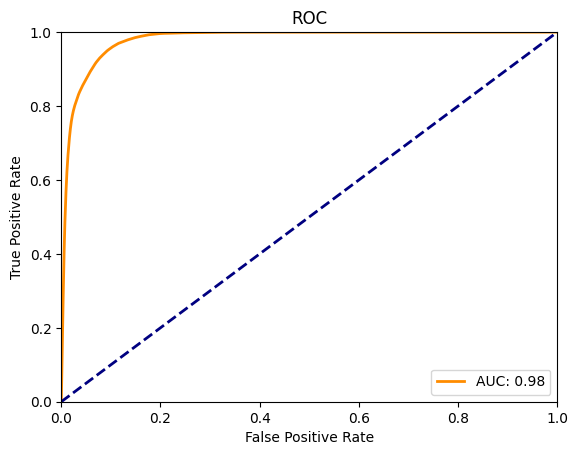

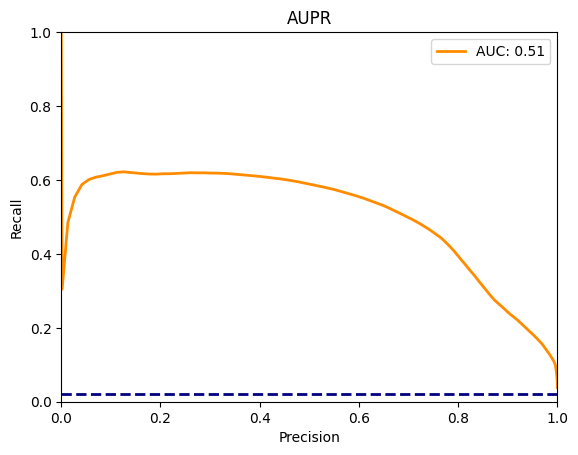

In [7]:
import torch
from anomalib.utils.metrics import AUROC, AUPR

metrics = [AUROC(), AUPR()]

for metric in metrics:
    metric.cpu()
    metric.update(anomaly_maps, masks)

for metric in metrics:
    print(f"{metric}={metric.compute()}")
    metric.generate_figure()

# Area Under the Per-Image Overlap (AUPImO)

In [8]:
from anomalib.utils.metrics.perimg import AUPImO

aupimo = AUPImO(num_thresholds=10_000)
aupimo.cpu()
aupimo.update(anomaly_maps, masks)

/home/jcasagrandebertoldo/repos/anomalib/src/anomalib/utils/metrics/perimg/binclf_curve.py:317: UserWarning: Metric `AUPImO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(


The AUPImO has a shared X-axis and a per-image Y-axis.

The X-axis is a metric of False Positives in the normal images.

The Y-axis is the overlap between the binary predicted mask and the ground truth mask of anomalous images, which corresponds to the True Positive Rate (TPR) in a single image.

In [9]:
%%time
thresholds, fpr, tprs, aucs = aupimo.compute()
print(f"{thresholds.shape=}")
print(f"{fpr.shape=}")
print(f"{tprs.shape=}")
print(f"{aucs.shape=}")

thresholds.shape=torch.Size([10000])
fpr.shape=torch.Size([10000])
tprs.shape=torch.Size([110, 10000])
aucs.shape=torch.Size([110])
CPU times: user 2.9 s, sys: 0 ns, total: 2.9 s
Wall time: 2.6 s


Notice that `aucs` has the number of images seen in `outputs`.

In [10]:
masks.shape

torch.Size([110, 256, 256])

which includes normal images.

However, the `Per-Image Overlap`, by definition, is not defined on the normal images, so they have `nan`s.

In [11]:
aucs

tensor([0.9938, 0.9949, 0.9862, 0.9910, 0.9966, 0.9956, 0.9913, 0.9799, 0.9969,
        0.9802, 0.9646, 0.9908, 0.9592, 0.9852, 0.9923, 0.9859, 0.9932, 0.9720,
        0.9973, 0.9919, 0.9955, 0.9967, 0.9943, 0.9969, 0.9926, 0.9966, 0.9807,
        0.9945, 0.9970, 0.9969, 0.9972, 0.9945, 0.9879, 0.9942, 0.9954,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan, 0.9980, 0.9991, 0.9992, 0.9987, 0.9990, 0.9982,
        0.9900, 1.0000, 0.9982, 0.9982, 0.9969, 0.9854, 0.9911, 0.9963, 0.9760,
        0.9991, 0.9763, 0.9968, 0.9986, 0.9989, 0.9994, 0.9936, 0.9990, 0.9897,
        0.9992, 0.9982, 0.9995, 0.9971, 0.9992, 0.9980, 0.9989, 0.9934, 0.9965,
        0.9974, 0.9981], dtype=torch.flo

This is intentional. This way, the indexes in `aucs` correspond to the indices of the actual images.

One can now analyze the destribution of this True Posivity metric across images:

In [12]:
import scipy as sp

sp.stats.describe(aucs[~torch.isnan(aucs)])

DescribeResult(nobs=70, minmax=(0.9592010778751013, 0.9999511186178629), mean=0.9928704122129502, variance=6.791122573949679e-05, skewness=-2.1209092075173546, kurtosis=4.606183964491857)